In [1]:
%loadlibs
from utils import load_datasets, rnmse
import torch.fft as fft

Loaded libraries:
	- numpy (np)
	- matplotlib.pyplot (plt)
	- torch
	- torch.nn (nn)
	- torch.optim (optim)
	- tqdm


In [2]:
nx, nt = 128, 256
n_epochs = 100
l_r = 1e-3
dx = 1.0
dt = 0.001
device = 'mps'

In [3]:
train, val, test, x_min, x_max, c_min, c_max, y_min, y_max = load_datasets(2600, 100, 1000, 1)

Since the acoustic wave equation is given by

$$\frac{\partial^2 p}{\partial t^2} = c^2 \nabla^2 p$$

Any NN that respects this equality should play the role of a valid simulator. This means that we can build a NN $\hat{f}(p_{t-\delta t}) = \hat{p}$ that minimizes a loss term

$$L = (\frac{\partial^2 \hat{p}}{\partial t^2} - c^2 \nabla^2 \hat{p}-s)^2$$

for any input $p_{t-\delta t}$.

In [4]:
def loss_fn(p_t_pdt, p_t_mdt, p, c, s, dx, dt):
    p_x_m2dx_y = torch.roll(p, -2, dims=0)
    p_x_mdx_y = torch.roll(p, -1, dims=0)
    p_x_pdx_y = torch.roll(p, 1, dims=0)
    p_x_p2dx_y = torch.roll(p, 2, dims=0)

    p_x_y_m2dy = torch.roll(p, -2, dims=1)
    p_x_y_mdy = torch.roll(p, -1, dims=1)
    p_x_y_pdy = torch.roll(p, 1, dims=1)
    p_x_y_p2dy = torch.roll(p, 2, dims=1)
    
    return ((p_t_pdt - dt**2 * (s + c**2 * (-p_x_m2dx_y + 16*p_x_mdx_y - 60*p + 16*p_x_pdx_y - p_x_p2dx_y 
                                     - p_x_y_m2dy + 16*p_x_y_mdy + 16*p_x_y_pdy - p_x_y_p2dy)/(12*dx**2)) + p_t_mdt - 2*p)**2).mean()

And we optimize a simple NN:

In [5]:
nt = 64

In [6]:
from utils import ricker
def init(c):
    isx = 1
    isz = nx // 2
    f0  = 15 * 5
    dx = 1.0
    dt = 0.001
    
    t = torch.arange(1, nt+1, device=device) * dt
    T0 = 1.0 / (15 * 5)

    tmp = torch.diff(torch.tensor(ricker(dt, T0), device=device, dtype=torch.float32))*1e2
    src = torch.zeros(nt, device=device, dtype=torch.float32)
    src[:tmp.numel()] = tmp

    lam = c * T0
    
    x = torch.arange(nx, device=device) * dx
    z = x.clone()

    sigma = 1.5 * dx
    x0, z0 = x[isx], z[isz]

    xx = x[:, None]
    zz = z[None, :]

    sg = torch.exp(-((xx - x0)**2 + (zz - z0)**2) / sigma**2)
    sg = sg / sg.max()
    return sg, src

sg, src = init(torch.ones((nx, nx)))
s = (sg.unsqueeze(0) * src.unsqueeze(-1).unsqueeze(-1))
print(sg.unsqueeze(0).shape, src.shape, s.shape)

torch.Size([1, 128, 128]) torch.Size([64]) torch.Size([64, 128, 128])


In [7]:
from neuralop import FNO

Error: trying to import DISCO convolutions without optional dependency torch-harmonics.  Please install with `pip install torch-harmonics` and retry.


In [8]:
class PINN(nn.Module):
    def __init__(self, hidden_channels=32):
        super().__init__()

        self.net = nn.Sequential(
            nn.Conv2d(2, hidden_channels, kernel_size=3, padding="same"),
            nn.Tanh(),
            nn.Conv2d(hidden_channels, hidden_channels, kernel_size=3, padding="same"),
            nn.Tanh(),
            nn.Conv2d(hidden_channels, 1, kernel_size=3, padding="same")
        )
        #self.net2 = nn.Sequential(
        #    FNO(n_modes=(32, 32), in_channels=2, out_channels=1, hidden_channels=2),
            #nn.Tanh()
        #)

    def forward(self, u, c, s, dt):
        inp = torch.stack([u, c], dim=0).unsqueeze(0)
        out = (self.net(inp))
        return out[0, 0] + s*dt**2

model = PINN().to(device)

In [9]:
c = 300*torch.ones((nx, nx)).to(device)

In [10]:
opt = torch.optim.Adam(model.parameters(), lr=5e-5)
model.train()
n_steps = nt
losses = []
for epoch in (pbar:=tqdm(range(10000))):
    for _ in range(10):
        u_prev = torch.randn((nx, nx)).to(device)*1e-6
        u = model(u_prev, c, s[0], dt)
        loss = 0
        opt.zero_grad()
        for it in range(1, n_steps):
            u_pred = model(u, c, s[it], dt)
            loss += loss_fn(u_pred, u_prev, u, c, s[it], dx, dt)
            u_prev = u.detach()
            u = u_pred.detach()
        loss.backward()
        losses.append(loss.item())
        opt.step()
        pbar.set_postfix(loss=np.mean(losses[-20:]))

  0%|          | 0/10000 [00:00<?, ?it/s]

To evaluate the model, we compare its trace with a simple FD one.

In [11]:
@torch.compile
def fd_step(ap, apold, c, dt, dx, s):
    return ap, 2*ap - apold +  dt**2 * (c**2 * (
            ((-torch.roll(ap, -2, dims=0) + 16 * torch.roll(ap, -1, dims=0) - 60 * ap + 16 * torch.roll(ap,  1, dims=0) - torch.roll(ap,  2, dims=0) +
            (-torch.roll(ap, -2, dims=1) + 16 * torch.roll(ap, -1, dims=1) + 16 * torch.roll(ap,  1, dims=1) - torch.roll(ap,  2, dims=1))) / (12 * dx**2))
        ) + s)


kx = 2 * torch.pi * torch.fft.fftfreq(nx, d=dx, device="mps")
kx2 = -(kx**2).reshape(-1, 1)
kz2 = -(kx**2).reshape(1, -1)

@torch.compile
def spectral_step(sp, spold, c, dt, s):
    sp_fft = fft.fft2(sp)
    return sp, 2*sp - spold + (c**2 * (fft.ifft2(sp_fft * kx2).real + fft.ifft2(sp_fft * kz2).real) + s) * dt**2

In [12]:
def get_traces(c, nx, device="mps"):
    shape = (nx, nx)
    zeros = lambda: torch.zeros(shape, device=device, dtype=torch.float32)

    ap    = zeros()
    apnew = zeros()
    apold = zeros()
    ad2px = zeros()
    ad2pz = zeros()

    trace_ps = []
    for it in (range(nt)):
        apold, ap = fd_step(ap, apold, c, dt, dx, s[it])
        trace_ps.append(ap[0].detach().cpu())
    return torch.stack(trace_ps)

In [13]:
model.eval()
t = []
u_prev = torch.zeros((nx, nx)).to(device)
u = model(u_prev, c, s[0], dt)
for it in range(1, n_steps):
    u_pred = model(u, c, s[it], dt)
    t.append(u_pred[0].clone().cpu().detach())
    u_prev = u
    u = u_pred

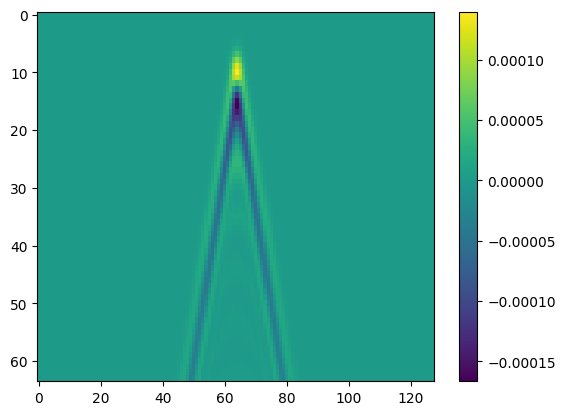

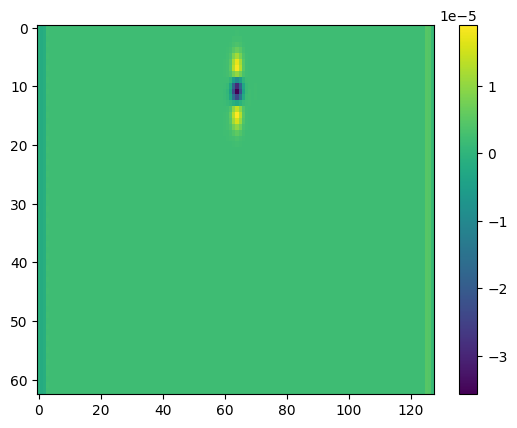

In [14]:
plt.imshow(get_traces(c, nx), aspect='auto')
plt.colorbar()
plt.show()
plt.imshow(torch.stack(t).cpu().detach(), aspect="auto")
plt.colorbar()
plt.show()